In [1]:
!git clone https://github.com/NCTU-VRDL/tensorflow2_yolov3.git


Cloning into 'tensorflow2_yolov3'...
remote: Enumerating objects: 1449, done.
remote: Counting objects: 100% (1449/1449), done.
remote: Compressing objects: 100% (1099/1099), done.
remote: Total 1449 (delta 402), reused 1314 (delta 331), pack-reused 0
Receiving objects: 100% (1449/1449), 15.02 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (402/402), done.


In [2]:
%cd tensorflow2_yolov3

/home/psliu/NCTU-VRDL/tensorflow2_yolov3/tensorflow2_yolov3


In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-29 12:18:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  18.4MB/s    in 14s     

2021-04-29 12:18:55 (17.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## YOLO-V3 架構圖
![alt text](https://gitee.com/yunyang1994/BlogSource/raw/master/hexo/source/images/YOLOv3/levio.png)

In [4]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from core.yolov3 import *
from PIL import Image
tf.keras.backend.clear_session()

input_size   = 416
image_path   = "./docs/kite.jpg"

input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(model, "./yolov3.weights")

/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/psliu/NCTU-VRDL/lib/python3.6/site-packages/tensorboard/co

In [5]:
feature_maps[2].shape

TensorShape([None, 13, 13, 255])

In [6]:
pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)
bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.45, method='nms')

image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)

In [7]:
pred_bbox = model.predict(image_data)

In [8]:
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...].astype(np.float32)

In [9]:
??utils.image_preporcess

Signature: utils.image_preporcess(image, target_size, gt_boxes=None)
Docstring: <no docstring>
Source:   
def image_preporcess(image, target_size, gt_boxes=None):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes
File:      ~/NCTU-VRDL/tensorflow2_yolov3/tensorflow2_yolov3/core/utils.py
Type:      function


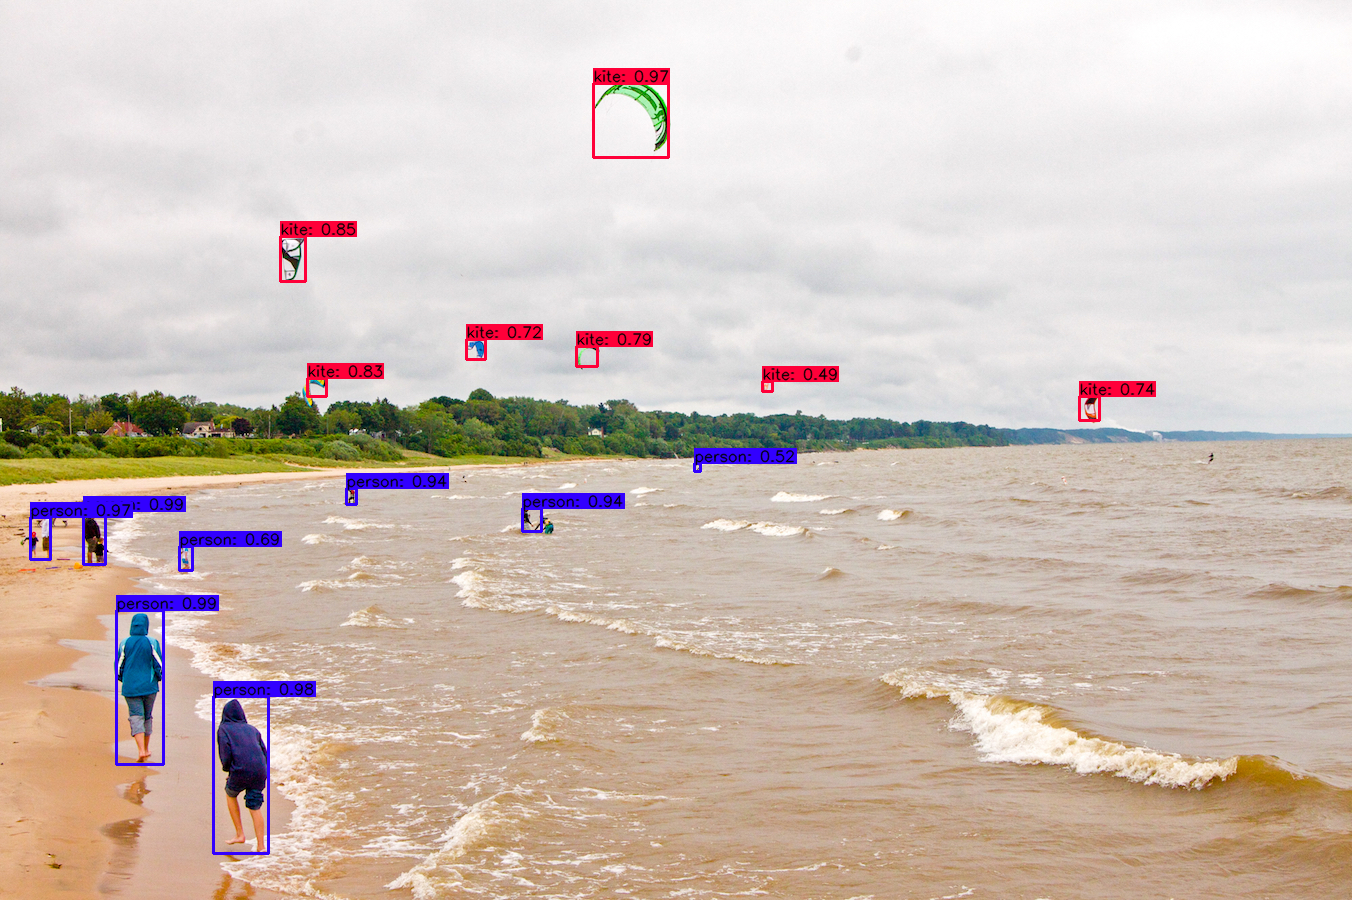

In [10]:
image

In [11]:
pred_bbox[1][0,21,4,2,6:]

array([3.49864364e-03, 1.23419464e-02, 7.76439905e-04, 6.34649396e-03,
       5.64903021e-03, 1.25554204e-03, 1.36283338e-02, 7.40574718e-01,
       1.16378069e-04, 7.00086355e-04, 2.50101089e-04, 1.93625689e-04,
       7.23481178e-03, 1.18752122e-02, 4.72962856e-05, 4.22447920e-04,
       3.88631225e-03, 2.22116709e-04, 6.87450171e-04, 1.04644895e-03,
       1.10119581e-04, 4.82976437e-04, 3.92413139e-03, 1.89632177e-04,
       6.89646602e-02, 3.90052795e-04, 7.17639923e-05, 5.89549541e-04,
       1.28716230e-04, 1.74179673e-03, 2.35438347e-04, 1.93208456e-04,
       7.36882091e-02, 4.11361456e-04, 2.54511833e-05, 2.65359879e-04,
       3.46122384e-02, 4.83095646e-04, 2.71499157e-04, 1.14685297e-03,
       8.60989094e-05, 9.82284546e-04, 1.16825104e-04, 3.14921141e-04,
       1.88589096e-04, 5.24848700e-04, 1.25855207e-04, 2.07811594e-04,
       4.57018614e-04, 1.65104866e-05, 3.53544950e-04, 5.68628311e-05,
       1.95771456e-04, 2.47955322e-05, 4.76598740e-04, 8.35703611e-02,
      

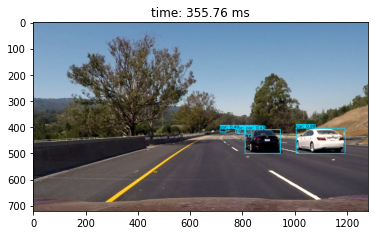

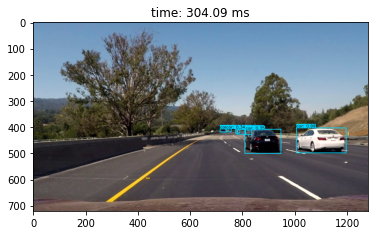

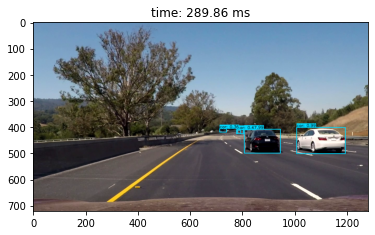

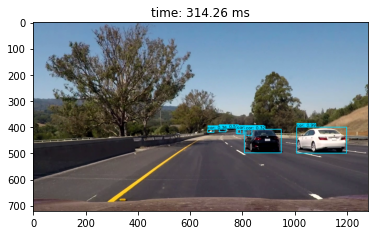

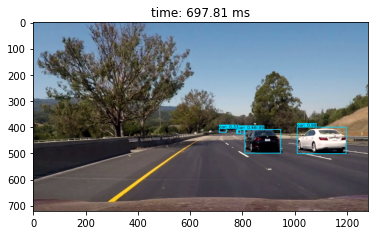

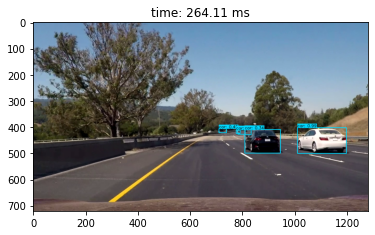

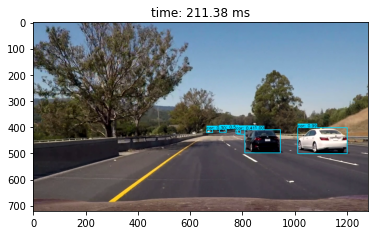

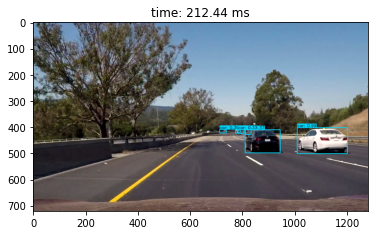

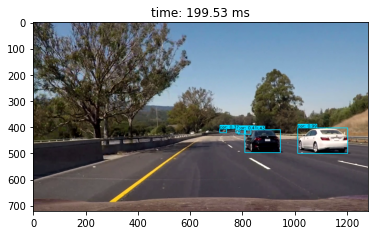

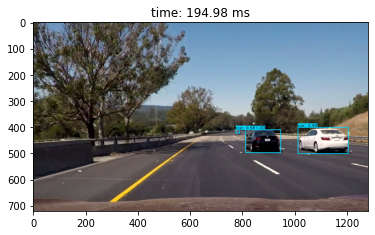

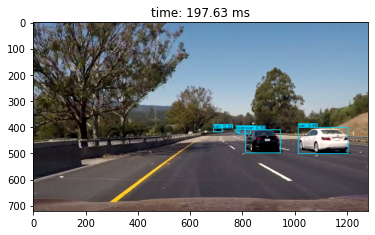

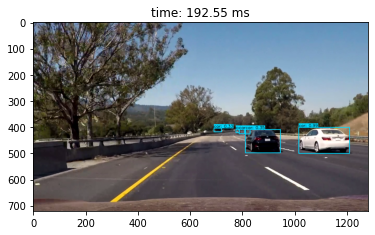

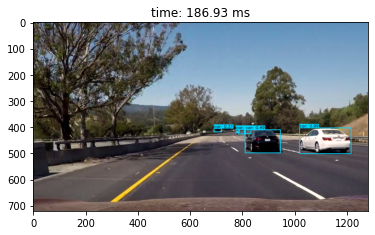

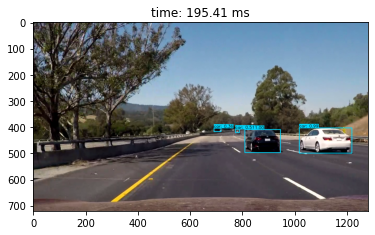

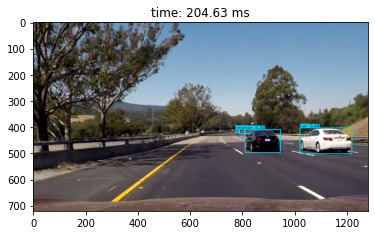

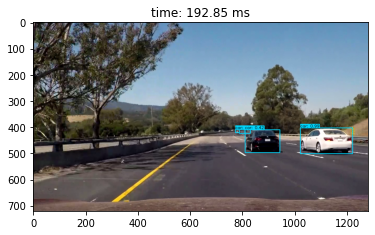

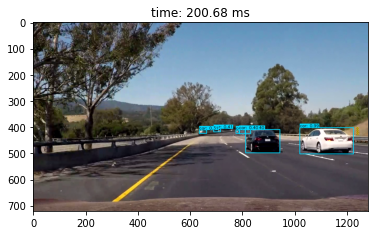

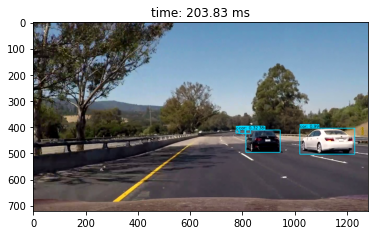

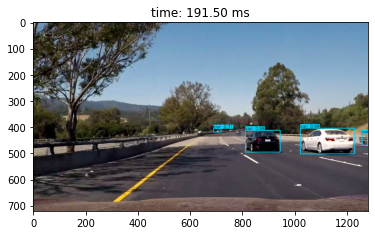

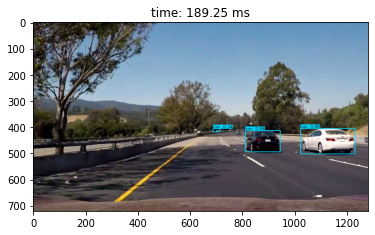

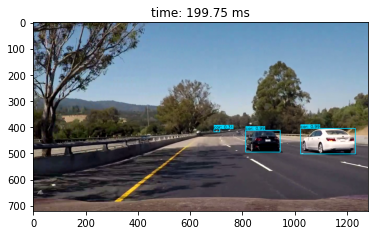

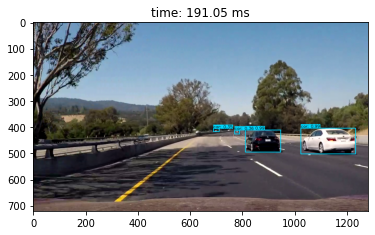

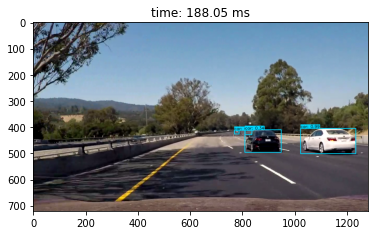

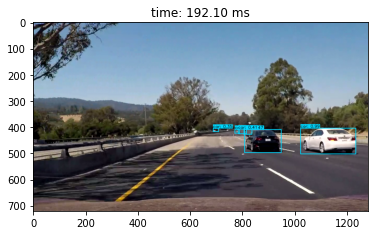

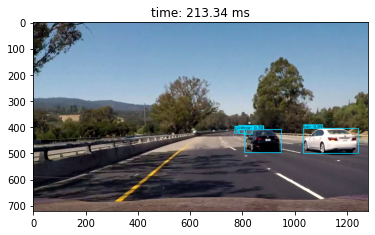

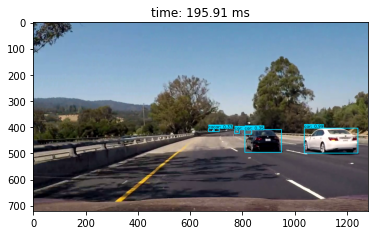

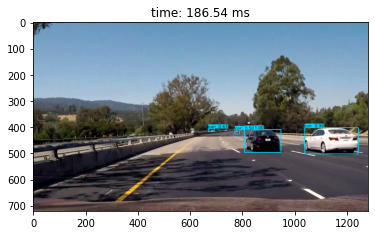

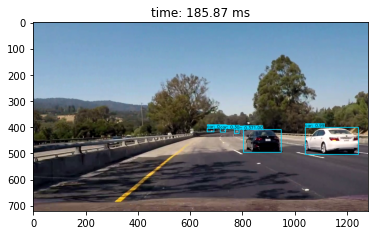

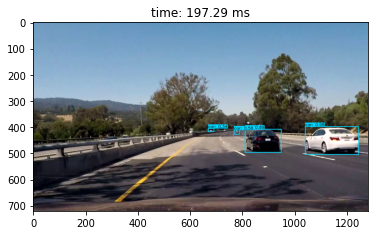

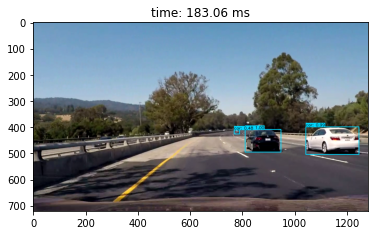

In [12]:
import time
import matplotlib.pyplot as plt

video_path      = "./docs/road.mp4"

num_classes     = 80
input_size      = 416

vid = cv2.VideoCapture(video_path)
for _ in range(30):
    return_value, frame = vid.read()
    if return_value:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("No image!")
    frame_size = frame.shape[:2]
    image_data = utils.image_preporcess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)

    prev_time = time.time()
    pred_bbox = model.predict_on_batch(image_data)
    curr_time = time.time()
    exec_time = curr_time - prev_time

    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox, frame_size, input_size, 0.3)
    bboxes = utils.nms(bboxes, 0.45, method='nms')
    image = utils.draw_bbox(frame, bboxes)

    result = np.asarray(image)
    info = "time: %.2f ms" %(1000*exec_time)
    plt.title(info)
    plt.imshow(result)
    plt.show()